# 基于Spark的地震数据处理与分析
Time: 2020-11-21 Author: dsy

## 1. 环境准备

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
conf = SparkConf().setMaster("local").setAppName("analyze")
sc = SparkContext(conf = conf)
sc.setLogLevel('WARN') # 减少不必要的log输出
spark = SparkSession.builder.config(conf = SparkConf()).getOrCreate()
 
dataFile = 'data/earthquake.csv'
 
rawData = spark.read.format('csv') \
                    .options(header='true', inferschema='true') \
                    .load(dataFile) 
rawData.createOrReplaceTempView("earthquake")

## 2. 全球每年发生重大地震的次数

In [3]:
# 全球每年发生重大地震的次数
def earthquakesPerYear():
    
    yearDF = spark.sql("select year,count(year) as year_count from (select Year(to_date(Date,'MM/dd/yyyy')) as year from earthquake) where year is not NULL group by year order by year")
    yearPd = yearDF.toPandas()
#     # 数据可视化
    plt.bar(yearPd['year'], yearPd['year_count'], color='skyblue')
    plt.title('earthquakes per year')
    plt.xlabel('year')
    plt.ylabel('count')
    plt.show()

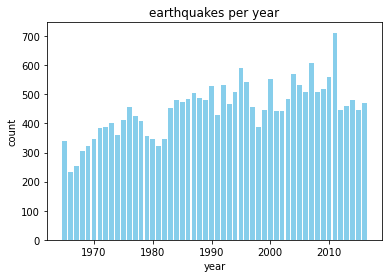

In [4]:
earthquakesPerYear()

In [5]:
# 全球不同年份每月发生重大地震的次数
def earthquakesPerMonth():
    
#     spark.sql("select * from earthquake order by date").show(100)
    
    yearPd=spark.sql("select year,month,count(month) as month_count  \
              from \
              (select Year(to_date(Date,'MM/dd/yyyy')) as year, \
                      Month(to_date(Date,'MM/dd/yyyy')) as month from earthquake) \
              where  year is not NULL and month is not NULL group by year,month order by year,month")\
    .toPandas()
    x = [m+1 for m in range(12)]
    for groupName, group in yearPd.groupby('year'):
        plt.scatter(x, group['month_count'], color='g', alpha=0.15)
    plt.title('earthquakes per month')
    plt.xlabel('Month')
    plt.show()

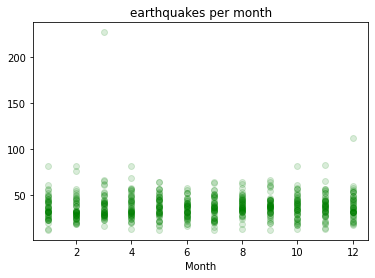

In [6]:
earthquakesPerMonth()

In [7]:
# 全球重大地震深度和强度之间的关系
def depthVsMagnitude():
    data = spark.sql("select Depth, Magnitude from earthquake \
    where Depth is not NULL and Magnitude is not NULL")
    vsPd = data.toPandas()
    # 数据可视化
    plt.scatter(vsPd.Depth, vsPd.Magnitude, color='g', alpha=0.2)
    plt.title('Depth vs Magnitude')
    plt.xlabel('Depth')
    plt.ylabel('Magnitude')
    plt.show()

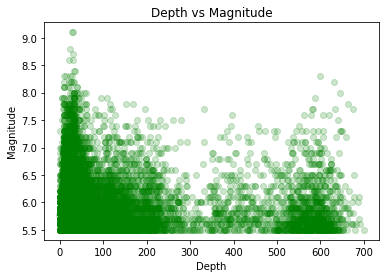

In [8]:
depthVsMagnitude()

In [9]:
# 全球重大地震深度和类型之间的关系
def magnitudeVsType():
    
    data = spark.sql("select Magnitude ,Type from earthquake where Magnitude is not NULL and Type is not NULL ")
#     .show(100)
    
#     return
    
#     data = rawData.select('Magnitude', 'Magnitude Type').dropna()
    typePd = data.toPandas()
    # 准备箱体数据
    typeBox = []
    typeName = []
    for groupName, group in typePd.groupby('Type'):
        typeName.append(groupName)
        typeBox.append(group['Magnitude'])
    # 数据可视化
    plt.boxplot(typeBox, labels=typeName)
    plt.title('Type vs Magnitude')
    plt.xlabel('Type')
    plt.ylabel('Magnitude')
    plt.show()

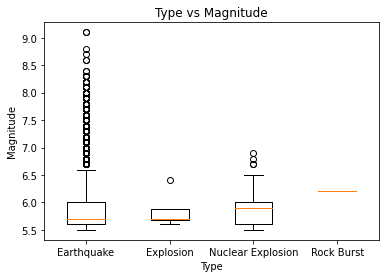

In [10]:
magnitudeVsType()

In [11]:
# 全球经常发生重大地震的地带
def location():
    from mpl_toolkits.basemap import Basemap
    data = spark.sql("select Latitude,Longitude, Magnitude from earthquake where Latitude is not NULL \
    and Longitude is  not NULL \
    and Magnitude is not NULL")
#     data = rawData.select('Latitude', 'Longitude', 'Magnitude').dropna()
    locationPd = data.toPandas()
    
    fig = plt.figure(figsize=(12, 8))
    # 世界地图
    basemap = Basemap()
    basemap.drawcoastlines()    # 绘制海岸线
    basemap.drawcountries()    # 绘制国界线
    # 数据可视化
    plt.scatter(locationPd.Longitude, locationPd.Latitude,
                color='g', alpha=0.25, s=locationPd.Magnitude)
    plt.title('Location')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

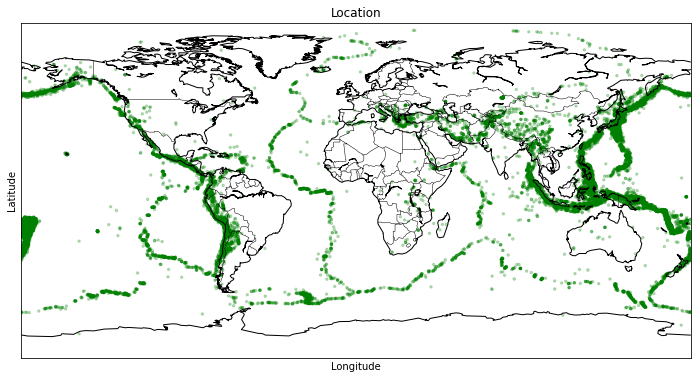

In [12]:
location()

In [13]:
spark.stop()